In [11]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *

from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os.path
import tweepy
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\RxN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) General sentiments of people - are they in favour of the Farm Bill or not - Classification. <br>
2) What are their main concerns - NER

## Dev Notes (for the group), delete this later
Regson (Preprocessing):
1) I only used the tweets which has not been truncated in the api - this means we are not actually working with 1000 tweets. We can increase max_items later to use more. <br>
2) I removed the all hashtags from tweets, but it might be useful keep them and just remove the "#" instead. The hash tag itself could hold some sentiment, this will need to be expiremented. <br>
3) I  removed stemmings, but im not sure how good this stemmings libaries is, we can give it a try with / without the stemming libiary and see what performs better? <br>
4) I removed the search terms "farmer" & "protest", because nearly every tweet contained this. <br>
5) I removed all non-ASCII text, this removed emojis and words written in hindi - I'm not sure if the sentiment libaries supports unicode but some emojis will definitely hold sentiment.  <br>

## Set up config information

In [25]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-25-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [26]:
USE_CSV = True

if not USE_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 1000
    result_type = "recent"
    lang = "en"
    # Do not include retweets or replies          
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets -filter:replies",
                             result_type=result_type, lang=lang).items(max_items)

    # Extract only the required keys from the response
    # Do not include truncated tweets
    tweets = [
        [tweet.created_at,
         tweet.text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified
        ] for tweet in response if (not tweet.truncated) ]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [29]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Truncated tweets were removed in the prior cell

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:\\.!?|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert text to lower case
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too, we may need this 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove the search terms
'''
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('farmer', '', x))
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('protest', '', x))
'''
# Remove any hashtags
# (!) NOTE: it might be possible that someone uses hashtag in midtext, so might need this
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
'''
min_word_length = 3
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))
'''
# Remove stemmings
# (?) NOTE: Maybe use a different stemming libary or keep stemmings
'''
stemmer = PorterStemmer()
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
'''
# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    can we have an investigation on this                                                         
1    captain saab amarinder you need to investigate this police officers need to be punished      
2    there is no compromise when it comes to injustice you have to fight it stand with our farmers
3    farmers in india are fighting for their livelihoods                                          
4    with farmers 4farmers                                                                        
Name: text_processed, dtype: object


 ## Word Cloud

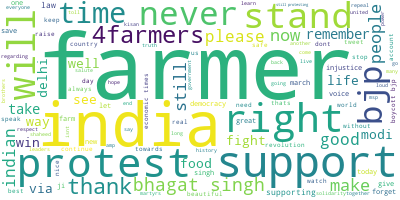

In [33]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

## Sentiment Analysis

            created_at  \
0  2021-03-22 23:16:07   
1  2021-03-22 23:14:39   
2  2021-03-22 23:14:12   
3  2021-03-22 23:12:51   
4  2021-03-22 22:55:32   

                                                                                                                                      text  \
0  Can we have an investigation on this @SukhpalKhaira #FarmersProtest https://t.co/qe5ttozzPE                                               
1  Captain Saab @capt_amarinder You need to investigate this. Police officers need to be punished. #FarmersProtest https://t.co/qe5ttozzPE   
2  There is no compromise when it comes to injustice. You have to fight it.Stand with our farmers\n\n #FarmersProtest\n\n 23:14:12           
3  Farmers in India are fighting for their livelihoods. 🙏✊🏼\n#IStandWithFarmers\n#FarmersProtest https://t.co/RT8djhdopQ                     
4  #23march with farmers #23March_किसानों_के_साथ #FarmersProtest #BoycottBJP_4Farmers                                                

<AxesSubplot:title={'center':'sentiment analysis'}>

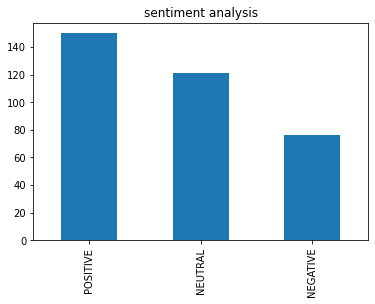

In [31]:
df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

sid = SentimentIntensityAnalyzer()

df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

print(df.head())
df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

## Named Entity Recognition

In [18]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
import spacy
import en_core_web_trf

  Using cached spacy_transformers-1.0.1-py2.py3-none-any.whl (38 kB)
Processing c:\users\rxn\appdata\local\pip\cache\wheels\3b\75\17\b11b16ad90276ff6e4e03ec375d55291a186c7fe9dbf87fba3\torchcontrib-0.0.2-py3-none-any.whl
  Using cached transformers-4.2.2-py3-none-any.whl (1.8 MB)


ERROR: Exception:
Traceback (most recent call last):


  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\cli\base_command.py", line 228, in _main
    status = self.run(options, args)
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\cli\req_command.py", line 182, in wrapper
    return func(self, options, args)
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\commands\install.py", line 397, in run
    installed = install_given_reqs(
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\req\__init__.py", line 82, in install_given_reqs
    requirement.install(
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\req\req_install.py", line 814, in install
    install_wheel(
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pip\_internal\operations\install\wheel.py", line 852, in install_wheel
    _install_wheel(
  File "C:\Users\RxN\AppData\Roaming\Python\Python38\site-packages\pi

  Using cached spacy_transformers-1.0.1-py2.py3-none-any.whl (38 kB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


In [32]:
nlp = spacy.load('en_core_web_sm')
unique_tweets = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')
unique_tweets_list = list(unique_tweets['text_processed'].values)

print(unique_tweets_list)

entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

print(entities)

['can we have an investigation on this', 'captain saab amarinder you need to investigate this police officers need to be punished', 'there is no compromise when it comes to injustice you have to fight it stand with our farmers', 'farmers in india are fighting for their livelihoods', 'with farmers 4farmers', 'what about covid 19 anyone', 'guys follow kro ranjit veere de account nu', 'no to rss', 'we stand with farmers', 'everyone please read and share', 'are you kidding me', 'salute to great martyrs and farmers jai kisan', 'they are all fake', 'honour our martyrs', 'his legacy continues', 'save agriculture support farmer protest', 'respect farmer support farmersprotest', 'its time to correct this grave mistake', 'bollywood starts who lost my respect', 'india stand against crony capitalism', 'day 117death toll 300', 'farmers will win', 'i have a feel the creator isnt too kind to genocidal narcissists', 'for my dearest andhbhakt', 'never forgot our martyrs', 'now days andhbakhts are getti

	NE found:  14 18 GPE nhai -- wondering how nhai makes annually from pan india tolls
	NE found:  25 33 DATE annually -- wondering how nhai makes annually from pan india tolls
	NE found:  43 48 GPE india -- wondering how nhai makes annually from pan india tolls
	NE found:  5 12 TIME evening -- good evening
	NE found:  0 11 DATE another day -- another day another tweet about whats been happening for four months
	NE found:  57 68 DATE four months -- another day another tweet about whats been happening for four months
	NE found:  15 19 CARDINAL half -- lets see glass half full at least they are not against farmers
	NE found:  31 36 GPE india -- these agents never want to see india grow
	NE found:  0 5 DATE today -- today with huge crowd farmers vidhansabha march held in bangalore
	NE found:  88 93 DATE today -- farmers protest spreads to banglore thousend of supporters marchew towards vidhan sabha today
	NE found:  101 106 GPE india -- considering silence to be nonviolence is a sign of our